# Goal: Identify depth in ecco to which heat content is asymmetric in SO
from Song et al. 2024: "we introduce an index, the “PmAI,” defined as the T700 of the Pacific sector (160E–60W, 46–61S) minus that of the Atlantic–Indian Ocean sector (60W–160E, 46–61s), to characterize zonally asymmetric variability in the upper Southern Ocean (Fig. 2c)...We extended our analysis by regressing the meridional mean temperature of the region spanning from 468 to 618S onto the PC1 and PmAI indices to investigate the vertical structure of the variability."

In this notebook, we want to calculate this quantity in ECCO and find a level to which we can integrate temperature to capture the asymmetry

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/glade/u/home/noahrose/ECCOv4-py/')
import ecco_v4_py as ecco

In [3]:
grid = xr.open_dataset('/glade/work/noahrose/ECCOV4r4/ECCO-GRID.nc')
theta = xr.open_mfdataset('/glade/work/noahrose/ECCOV4r4/nctiles_monthly/THETA/*/*.nc').THETA

In [6]:
theta.load();
grid.load();

<xarray.DataArray 'THETA' (time: 312, k: 50, tile: 13, j: 90, i: 90)> Size: 7GB
array([[[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 1.46380949e+00,  1.41187704e+00,  1.37486780e+00, ...,
            1.80948830e+00,  1.87334597e+00,  1.93178427e+00],
          [ 1.71169400e+00,  1.67474484e+00,  1.64544785e+00, ...,
            1.91703212e+00,  1.99166560e+00,  2.05868793e+00],
          [ 1.92983139e+00,  1.90576100e+00,  1.87788165e+00, ...,
            1.99231267e+00,  2.07472587e+00,  2.15449166e+00]],

         [[ 2.13417411e+00,  2.11420107e+00,  2.07142568e+00, ...,
            2.05049920e+00,  2.13055515e+00,  2.22112918e+00],
          [ 2.31679201e+00,  2.29222655e+00,  2.21569967e+00, ...,
            2.12422633e+00,  2.19792557e+00,  2.29675245e+00],
          [ 2.49553061e+00,  2.45979786e+00,  2.31774116e+00, ...,
            2.21942949e+00,  2.28396368e+00,  2.38735509e+00],
...
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]]],
      dtype=float32)
Coordinates:
  * k         (k) int64 400B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * j         (j) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i         (i) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile      (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC        (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC        (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    Z         (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    timestep  (time) int64 2kB 732 1428 2172 2892 ... 226452 227172 227904
  * time      (time) datetime64[ns] 2kB 1992-01-16T12:00:00 ... 2017-12-16
Attributes:
    units:          degC
    long_name:      Potential Temperature
    standard_name:  sea_water_potential_temperature

In [46]:
theta_ann = theta.resample(time='YS').mean('time')

In [14]:
gc_vol = grid.rA * grid.drF * grid.hFacC #volume of grid cells

In [21]:
so_mask = gc_vol.where((grid.YC >= -61)
                       & (grid.YC <= -48)
                        & (grid.Z >= -700))

In [22]:
pac_mask = so_mask.where((grid.XC < -60)
                         | (grid.XC >= 160))
atl_ind_mask = so_mask.where((grid.XC < 160)
                             & (grid.XC >= -60))

In [47]:
PmAI = (theta_ann * pac_mask).sum(('tile','i','j','k'))/pac_mask.sum() - (theta_ann * atl_ind_mask).sum(('tile','i','j','k'))/atl_ind_mask.sum()

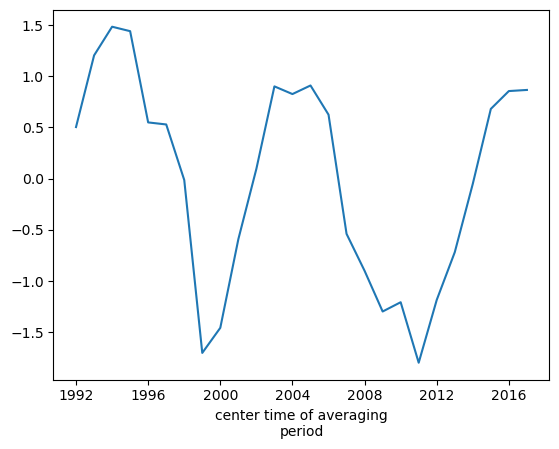

In [50]:
((PmAI - PmAI.mean('time'))/PmAI.std('time')).plot()

In [53]:
#calculate meridional mean temp

# regrid theta

lons, lats,_,_, theta_ann_rg =\
            ecco.resample_to_latlon(grid.XC, \
                                    grid.YC, \
                                    theta_ann,\
                                    -90, 90, 1,\
                                    -180, 180, 1,\
                                    fill_value = np.nan, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000);

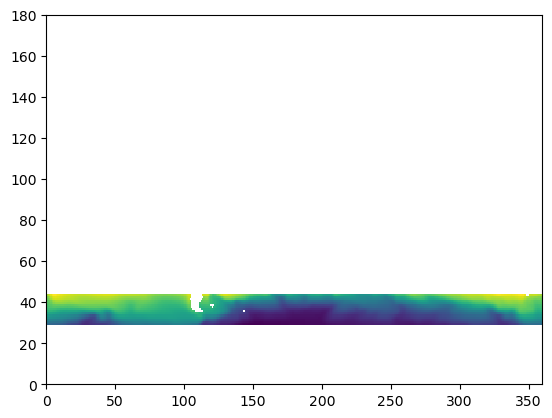

In [75]:
theta_ann_rg_so = np.where((theta_ann_rg != 0)
                            & (lats >= -61)
                            & (lats <= -46),
                           theta_ann_rg,np.nan)
plt.pcolormesh(theta_ann_rg_so[0,0])

In [76]:
theta_ann_rg_mm = np.nanmean(theta_ann_rg,axis=2)

/glade/derecho/scratch/noahrose/tmp/ipykernel_58510/4070933921.py:1: RuntimeWarning: Mean of empty slice
  theta_ann_rg_mm = np.nanmean(theta_ann_rg,axis=2)


In [85]:
theta_ann_rg_mm = (theta_ann_rg_mm - np.nanmean(theta_ann_rg_mm,axis=0))/np.nanstd(theta_ann_rg_mm,axis=0)

/glade/derecho/scratch/noahrose/tmp/ipykernel_58510/3048302629.py:1: RuntimeWarning: Mean of empty slice
  theta_ann_rg_mm = (theta_ann_rg_mm - np.nanmean(theta_ann_rg_mm,axis=0))/np.nanstd(theta_ann_rg_mm,axis=0)
/glade/work/noahrose/conda-envs/eccotools/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [95]:
#regress PmAI onto theta_ann_rg_mm
nt,nz,nx = theta_ann_rg_mm.shape
X = theta_ann_rg_mm.reshape(nt,nx*nz)
reg = PmAI.to_numpy()[np.newaxis,:].dot(X)

In [98]:
regmap = reg.reshape(nz,nx)

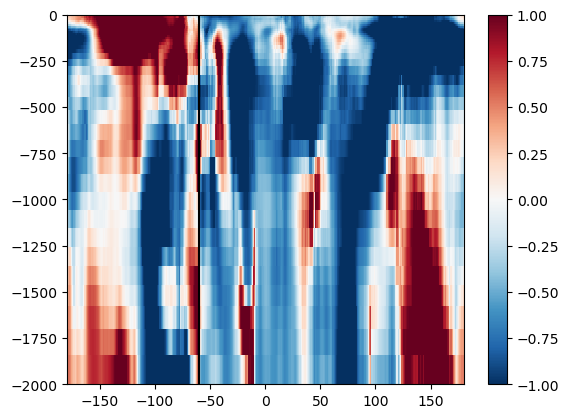

In [115]:
from matplotlib import colors
plt.pcolormesh(lons[0],grid.Z,regmap,cmap='RdBu_r',norm=colors.CenteredNorm(halfrange=1))
plt.ylim(-2000,0)
plt.axvline(-60,c='k')
plt.colorbar()